In [1]:
import boto3
import time
import json

session = boto3.Session(profile_name='nikita')
client = session.client('logs')


import numpy as np
import pandas as pd
import math
%pylab inline


from datetime import datetime, timezone

Populating the interactive namespace from numpy and matplotlib


# Query results

In [2]:
start = 0
results = []

while True:
    print('Querying')
    
    # Query for the first time begining in 1970
    query = client.start_query(
        logGroupName='/aws/batch/job',
        startTime=start,
        endTime=int(time.time()),
        queryString="""
            fields @message, @timestamp
            | filter success == 1
            | sort @timestamp asc
            | limit 10000
        """,
        limit=10000
    )

    # Loop untill the query response is ready
    query_result = {'status': 'Scheduled'}
    while query_result['status'] in ('Scheduled', 'Running'):
        query_result = client.get_query_results(queryId=query['queryId'])
        time.sleep(1)
    
    tmp = query_result
    
    # If we reached the end, we don't have any more data, we break
    if len(query_result['results']) == 0:
        break

    # If we did not reach the end, we get the timestamp of the last line and use this
    # as a starting point for the next iteration
    assert query_result['results'][-1][1]['field'] == "@timestamp"
    start = int(datetime.strptime(query_result['results'][-1][1]['value'], "%Y-%m-%d %H:%M:%S.%f").replace(tzinfo=timezone.utc).timestamp()) + 1

    # Process the data a little bit and push it to results
    data = [
        json.loads(row[0]['value'])
        for row in query_result['results']
    ]
    results += data

print(f"Done, with {len(results)} results")

Querying
Querying
Done, with 6945 results


In [3]:
with open("../eps_matrix2.out") as fd:
    text_data = [json.loads(line) for line in fd if line.startswith("{")]

In [4]:
for row in data:
    if row['winner'] is None:
        row['winner'] = 0.5

for row in text_data:
    if row['winner'] is None:
        row['winner'] = 0.5

df = pd.DataFrame(results + text_data)

In [5]:
from datetime import timedelta as td

class Player:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
class GreedyPlayer(Player):
    pass

class MCTSPlayer(Player):
    pass

class UCTPlayer(Player):
    pass

# Fix bad data
df['version'] = df.version.fillna(1).astype(int)
df['side'] = df['side'].fillna(-1).astype(int)

# Only keep usable data
df = df[df.version >= 2]

In [6]:
df.to_pickle("raw-results.pkl")

In [7]:
df.sample(5)

,player,opponent,duration,depth,score,winner,success,pool,side,version
40001,"GreedyPlayer(0, 0.5)","GreedyPlayer(1, 0.05)",0.0078,30,"[6, 26]",1.0,True,local-eps-matrix,0,2
26887,"GreedyPlayer(0, 0.6000000000000001)","GreedyPlayer(1, 0.8500000000000001)",0.0099,37,"[25, 8]",0.0,True,local-eps-matrix,0,2
43470,"GreedyPlayer(0, 0.65)","GreedyPlayer(1, 0.4)",0.0145,71,"[20, 23]",1.0,True,local-eps-matrix,1,2
35905,"GreedyPlayer(0, 0.8500000000000001)","GreedyPlayer(1, 0.55)",0.0054,20,"[3, 26]",1.0,True,local-eps-matrix,0,2
48936,"GreedyPlayer(0, 0.8)","GreedyPlayer(1, 0.6000000000000001)",0.0185,88,"[20, 26]",1.0,True,local-eps-matrix,1,2


In [8]:
is_normalized = df['side'] == 0

to_normalise = df[~is_normalized].copy()

# Swap columns
opponents = to_normalise['opponent'].copy()
players = to_normalise['player'].copy()

to_normalise['player'] = opponents
to_normalise['opponent'] = players

# Swap winner
to_normalise['winner'] = 1 - to_normalise['winner']

# Swap individual scores
to_normalise['score'] = to_normalise['score'].map(lambda x: list(reversed(x)))

# Concatenate the 2 sides
normalised = pd.concat([
    df[is_normalized].copy(),
    to_normalise.copy()
])


# Evaluate both players
normalised['player_eval'] = normalised['player'].map(lambda x: eval(x))
normalised['opponent_eval'] = normalised['opponent'].map(lambda x: eval(x))

# Plot


## MCTS time compare

In [18]:
mcts = normalised[normalised.pool == 'mcts_5s_time_compare_longer'].copy()
mcts['time'] = mcts.opponent_eval.map(lambda x: x.args[1].total_seconds())
grouped = mcts.groupby('time').winner.agg(['mean', 'count'])

In [19]:
grouped

,mean,count
time,,
0.5,0.30,10
1.0,0.20,10
1.5,0.25,10
2.0,0.50,10
3.0,0.40,10
5.0,0.60,10
7.0,0.50,10
10.0,0.70,10
15.0,0.70,10


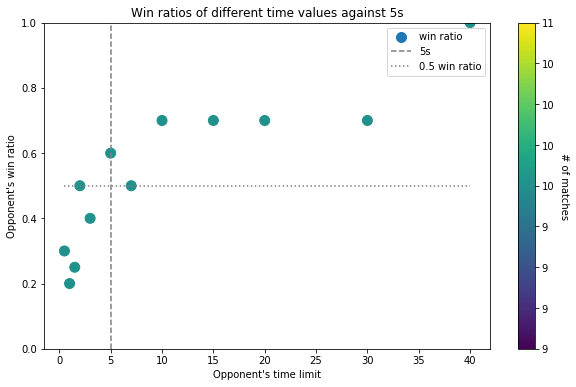

In [20]:
plt.figure(figsize=(10, 6))

plt.scatter(
    grouped.index,
    grouped['mean'],
    c=grouped['count'],
    label='win ratio',
    s=100
)

plt.vlines(5, 0, 1, linestyles='dashed', label="5s", color="grey")
plt.hlines(0.5, grouped.index.min() , grouped.index.max(), linestyles='dotted', label="0.5 win ratio", color="grey")
plt.legend()
cb = plt.colorbar()
cb.set_label('# of matches', rotation=270)
cb.ax.set_yticklabels([int(i) for i in cb.get_ticks()])
cb.ax.get_yaxis().labelpad = 15

plt.ylim(0, 1)

plt.title("Win ratios of different time values against 5s");
plt.xlabel("Opponent's time limit")
plt.ylabel("Opponent's win ratio");

## UTC c=1.5

In [12]:
uct = normalised[normalised.pool == 'uct-1_5-vs-range'].copy()
uct['c'] = uct.opponent_eval.map(lambda x: x.kwargs['c'])
grouped = uct.groupby('c').winner.agg(['mean', 'count'])

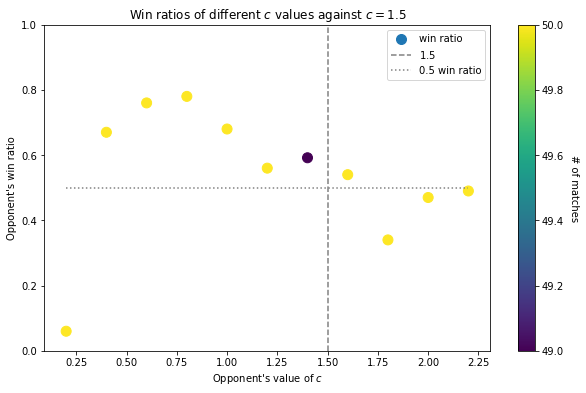

In [13]:
plt.figure(figsize=(10, 6))

plt.scatter(
    grouped.index,
    grouped['mean'],
    c=grouped['count'],
    label='win ratio',
    s=100
)

plt.vlines(1.5, 0, 1, linestyles='dashed', label="$1.5$", color="grey")
plt.hlines(0.5, grouped.index.min() , grouped.index.max(), linestyles='dotted', label="0.5 win ratio", color="grey")
plt.legend()
cb = plt.colorbar()
cb.set_label('# of matches', rotation=270)
#cb.ax.set_yticklabels([int(i) for i in cb.get_ticks()])
cb.ax.get_yaxis().labelpad = 15

plt.ylim(0, 1)

plt.title("Win ratios of different $c$ values against $c = 1.5$");
plt.xlabel("Opponent's value of $c$")
plt.ylabel("Opponent's win ratio");

In [14]:
np.linspace(0, 1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

## EPs matric

In [15]:
eps = normalised[normalised.pool == 'local-eps-matrix'].copy()
eps['eps1'] = eps.player_eval.map(lambda x: x.args[1])
eps['eps2'] = eps.opponent_eval.map(lambda x: x.args[1])

In [16]:
grouped = eps.groupby(['eps1', 'eps2']).winner.agg(['mean', 'count'])
grouped

mean  count
eps1 eps2              
0.0  0.00  0.415    100
     0.05  0.505    100
     0.10  0.495    100
     0.15  0.475    100
     0.20  0.405    100
...          ...    ...
1.0  0.80  0.710    100
     0.85  0.675    100
     0.90  0.605    100
     0.95  0.575    100
     1.00  0.560    100

[441 rows x 2 columns]

# Triangel pas d'aller retour

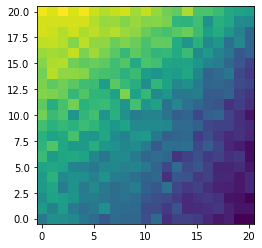

In [17]:
plt.imshow(grouped.drop('count', axis=1).unstack().values, origin='lower')